memory management

split-reward-training

- pretrain 77.32 +- 4.55
- scratch 72.16 +- 4.24

no-split-reward-training

- pretrain 79.8 +- 4.18
- scratch 75.68 +- 5.25


In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

import random

import numpy as np
from tqdm.auto import tqdm

from agent import HandcraftedAgent


capacity = {"episodic": 5, "episodic_agent": 1, "semantic": 1, "short": 1}


room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "wall",
        }
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1},
        },
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": 1.0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 99,
    "randomize_observations": False,
    "room_size": room_size,
}

results = {}

for mm_policy in ["episodic", "random", "generalize"]:
    for qa_policy in ["random", "episodic", "episodic_semantic"]:
        for explore_policy in ["random", "avoid_walls"]:
            for pretrain_semantic in [True, False]:
                key = (
                    mm_policy,
                    qa_policy,
                    explore_policy,
                    pretrain_semantic,
                )
                if key not in results:
                    results[key] = []
                print(key)

                for seed in tqdm([0, 1, 2, 3, 4]):
                    config["seed"] = seed

                    agent = HandcraftedAgent(
                        env_str="room_env:RoomEnv-v2",
                        env_config=config,
                        mm_policy=mm_policy,
                        qa_policy=qa_policy,
                        explore_policy=explore_policy,
                        num_samples_for_results=10,
                        capacity=capacity,
                        pretrain_semantic=pretrain_semantic,
                    )
                    agent.test()
                    agent.remove_results_from_disk()
                    to_append = (np.mean(agent.scores), np.std(agent.scores))
                    # print(to_append)
                    results[key].append(to_append)

In [ ]:
print(
    f"{'memory mgmt':<20}{'qa':<20}{'explore':<20}{'pretrain_semantic':<20}{'mean':<10}{'std':<10}"
)
print(f"-" * 110)
for key, val in results.items():
    print(
        f"{str(key[0]):<20}{str(key[1]):<20}{str(key[2]):<20}{str(key[3]):<20}{round(np.mean([v[0] for v in val]), 2):<10}{round(np.std([v[0] for v in val]), 2):<10}"
    )

memory mgmt         qa                  explore             pretrain_semantic   mean      std       
--------------------------------------------------------------------------------------------------------------
episodic            random              random              True                -2.92     1.34      
episodic            random              random              False               -2.92     1.34      
episodic            random              avoid_walls         True                -2.92     1.34      
episodic            random              avoid_walls         False               -2.92     1.34      
episodic            episodic            random              True                100.0     0.0       
episodic            episodic            random              False               100.0     0.0       
episodic            episodic            avoid_walls         True                100.0     0.0       
episodic            episodic            avoid_walls         False               1

In [ ]:
agent.memory_systems

In [ ]:
from explicit_memory.utils import read_yaml

q_values = read_yaml("training_results/random=True_pretrain=False/q_values.yaml")

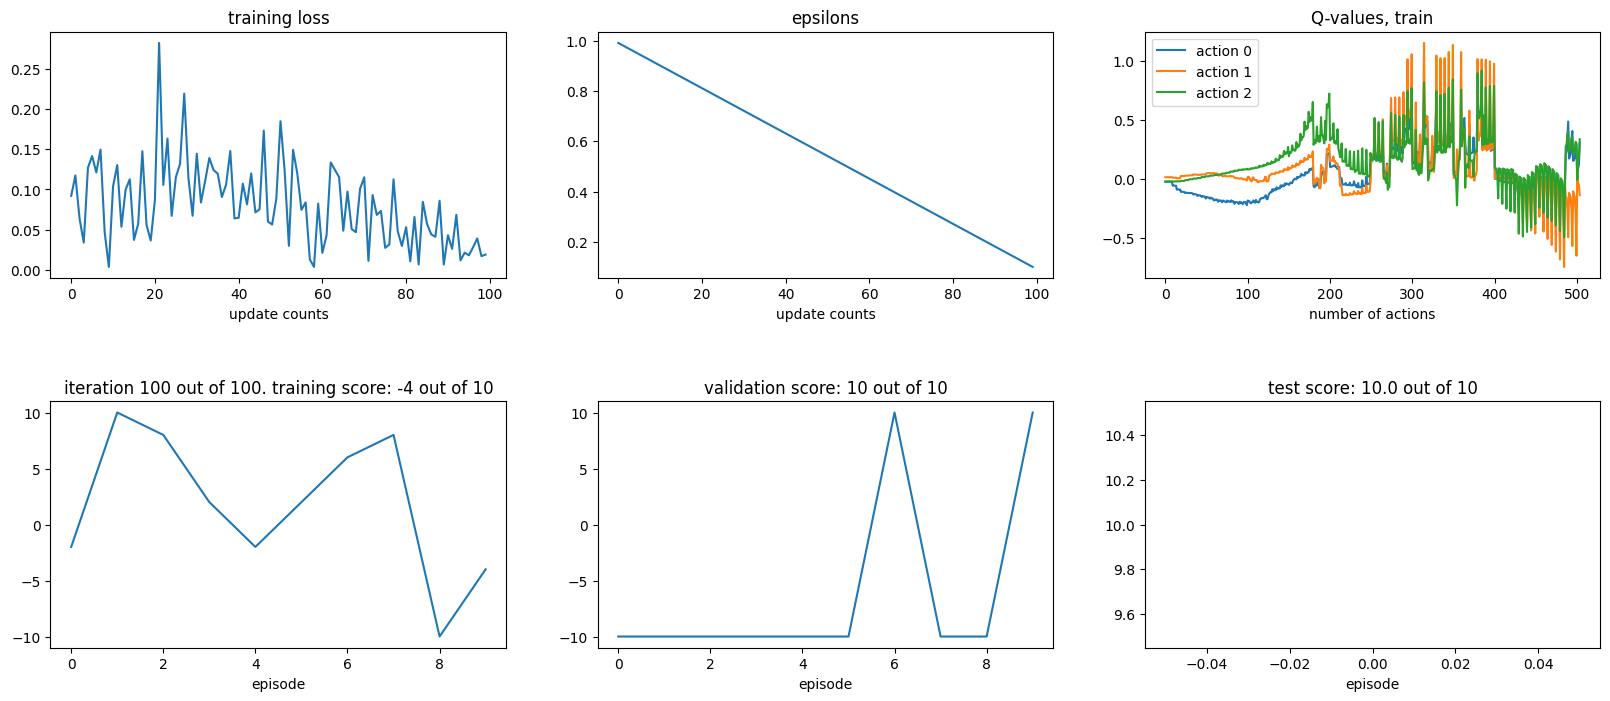

In [2]:
import logging

logger = logging.getLogger()
logger.disabled = True

import random

from agent.dqn import DQNMMAgent

room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "wall",
        }
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1},
        },
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": 1.0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 9,
    "randomize_observations": False,
    "room_size": room_size,
}

for pretrain_semantic in [False]:
    for test_seed in [0]:
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 10 * 10,
            "gamma": 0.5,
            "capacity": {
                "episodic": 5,
                "episodic_agent": 1,
                "semantic": 1,
                "short": 1,
            },
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
                "memory_of_interest": [
                    "episodic",
                    "semantic",
                    "short",
                ],
            },
            "num_iterations": 10 * 10,
            "replay_buffer_size": 128,
            "warm_start": 16,
            "batch_size": 16,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "qa_policy": "episodic_semantic",
            "explore_policy": "avoid_walls",
            "env_config": config,
            "ddqn": False,
            "dueling_dqn": False,
            "split_reward_training": False,
        }

        agent = DQNMMAgent(**all_params)
        agent.train()

In [3]:
len(agent.q_values["train"]), len(agent.q_values["val"]), len(agent.q_values["test"])

(504, 5000, 500)

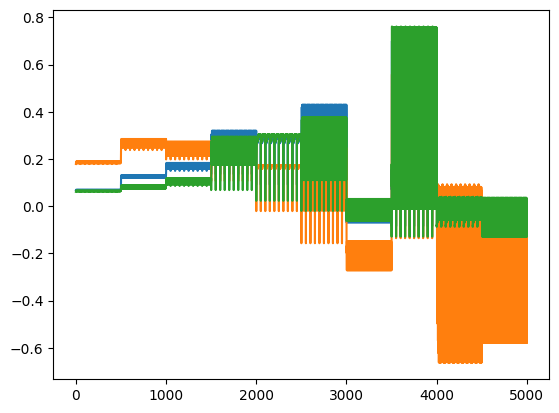

In [ ]:
import matplotlib.pyplot as plt

plt.plot(agent.q_values["val"][:5000])

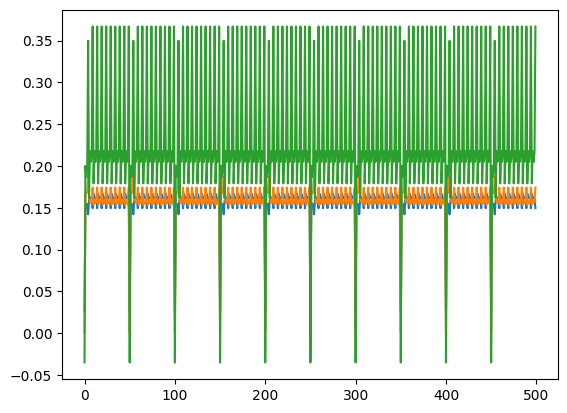

In [ ]:
import matplotlib.pyplot as plt

plt.plot(agent.q_values["test"][:5000])

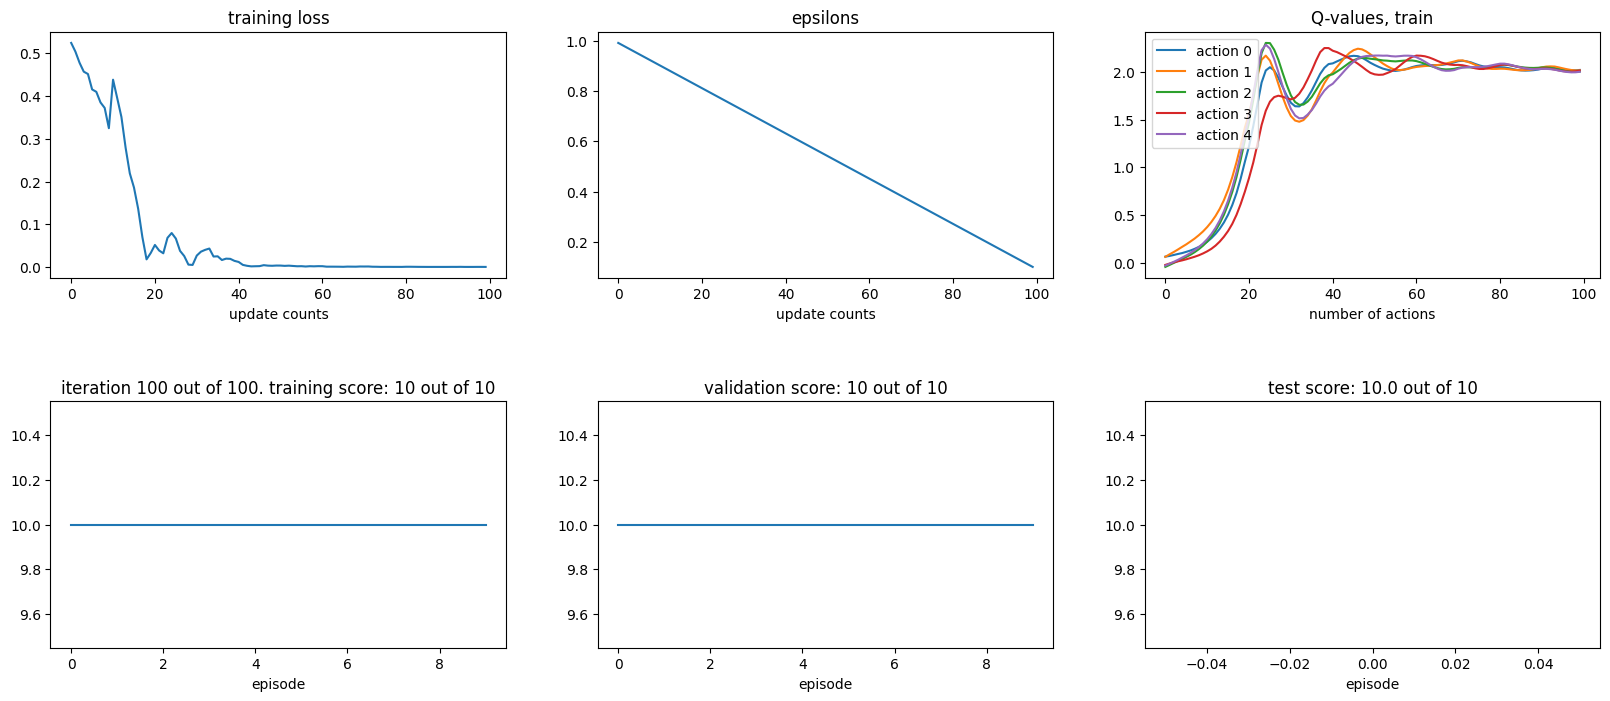

In [5]:
import logging

logger = logging.getLogger()
logger.disabled = True

import random

from agent.dqn import DQNExploreAgent

room_size = {
    "room_config": {
        "officeroom": {
            "north": "wall",
            "east": "wall",
            "south": "wall",
            "west": "wall",
        }
    },
    "object_transition_config": {
        "static": {"desk": None},
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": None}},
    },
    "object_init_config": {
        "static": {
            "desk": {"officeroom": 1},
        },
        "independent": {},
        "dependent": {},
        "agent": {"agent": {"officeroom": 1.0}},
    },
}
config = {
    "question_prob": 1.0,
    "seed": random.randint(0, 100000),
    "terminates_at": 9,
    "randomize_observations": False,
    "room_size": room_size,
}

for pretrain_semantic in [False]:
    for test_seed in [0]:
        all_params = {
            "env_str": "room_env:RoomEnv-v2",
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 10 * 10,
            "gamma": 0.5,
            "capacity": {
                "episodic": 5,
                "episodic_agent": 1,
                "semantic": 1,
                "short": 1,
            },
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 32,
                "v1_params": None,
                "v2_params": {},
                "memory_of_interest": [
                    "episodic",
                    "semantic",
                    "short",
                ],
            },
            "num_iterations": 10 * 10,
            "replay_buffer_size": 128,
            "warm_start": 16,
            "batch_size": 16,
            "target_update_rate": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "mm_policy": "episodic",
            "qa_policy": "episodic_semantic",
            "env_config": config,
            "ddqn": False,
            "dueling_dqn": False,
        }

        agent = DQNExploreAgent(**all_params)
        agent.train()

In [6]:
len(agent.q_values["train"]), len(agent.q_values["val"]), len(agent.q_values["test"])

(100, 1000, 100)

In [ ]:
agent.env.reset()

(([['agent', 'atlocation', 'officeroom', 0],
   ['desk', 'atlocation', 'officeroom', 0],
   ['officeroom', 'north', 'wall', 0],
   ['officeroom', 'east', 'wall', 0],
   ['officeroom', 'south', 'wall', 0],
   ['officeroom', 'west', 'wall', 0]],
  ['?', 'atlocation', 'officeroom', 0]),
 {})

In [ ]:
agent.env.step(("foo", "north"))

(([['agent', 'atlocation', 'officeroom', 1],
   ['desk', 'atlocation', 'officeroom', 1],
   ['officeroom', 'north', 'wall', 1],
   ['officeroom', 'east', 'wall', 1],
   ['officeroom', 'south', 'wall', 1],
   ['officeroom', 'west', 'wall', 1]],
  ['desk', 'atlocation', '?', 1]),
 -1,
 False,
 False,
 {'answers': ['desk'], 'timestamp': 0})

In [ ]:
len(agent.q_values["train"]), len(agent.q_values["val"]), len(agent.q_values["test"])

(44, 1000, 100)

In [ ]:
len(agent.q_values["val"][:100])

100

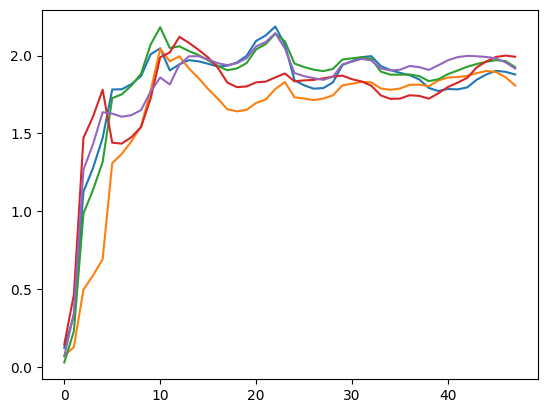

In [ ]:
plt.plot(agent.q_values["train"])

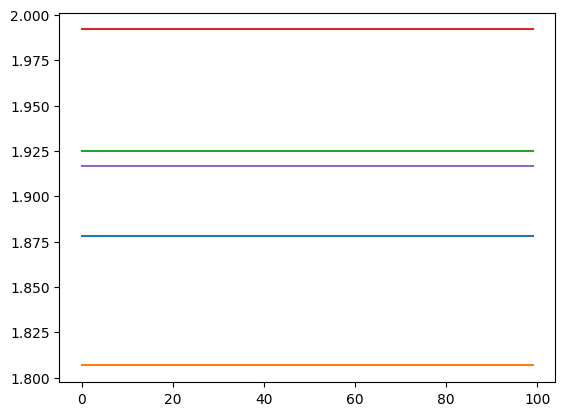

In [ ]:
plt.plot(agent.q_values["val"][900:1000])

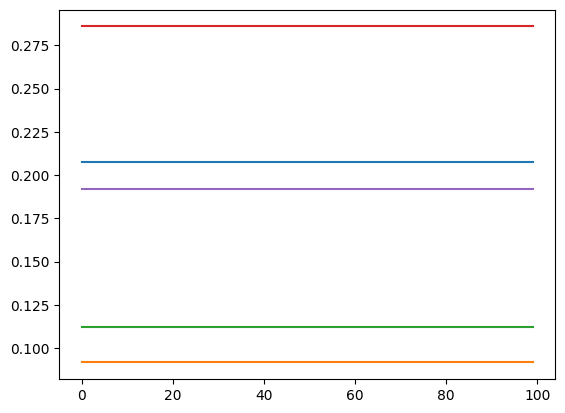

In [ ]:
plt.plot(agent.q_values["test"])

In [ ]:
from glob import glob
from explicit_memory.utils import read_yaml

results = {"pretrain": [], "scratch": []}
for foo in glob("./training_results/*/*train.yaml"):
    bar = read_yaml(foo)
    # print(foo, bar["test_seed"], bar["pretrain_semantic"])

    foo_ = foo.replace("train.yaml", "results.yaml")

    bar_ = read_yaml(foo_)
    if bar["pretrain_semantic"]:
        results["pretrain"].append(bar_["test_score"])
    else:
        results["scratch"].append(bar_["test_score"])


foo = [foo["mean"] for foo in results["scratch"]]
print(f"{'scratch':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

foo = [foo["mean"] for foo in results["pretrain"]]
print(f"{'pretrain':<15}{round(np.mean(foo), 2)}  +-  {round(np.std(foo), 2)}")

In [ ]:
from glob import glob
from copy import deepcopy
from explicit_memory.utils import read_yaml
import os

results = {
    "split-reward-training": {"pretrain": [], "scratch": []},
    "no-split-reward-training": {"pretrain": [], "scratch": []},
}

for foo in deepcopy(glob("./training_results/mm/*/train.yaml")):
    baz = foo.replace("train.yaml", "results.yaml")
    bar = read_yaml(foo)
    qux = read_yaml(baz)
    if bar["split_reward_training"]:
        if bar["pretrain_semantic"]:
            results["split-reward-training"]["pretrain"].append(
                qux["test_score"]["mean"]
            )
        else:
            results["split-reward-training"]["scratch"].append(
                qux["test_score"]["mean"]
            )
    else:
        if bar["pretrain_semantic"]:
            results["no-split-reward-training"]["pretrain"].append(
                qux["test_score"]["mean"]
            )
        else:
            results["no-split-reward-training"]["scratch"].append(
                qux["test_score"]["mean"]
            )

In [ ]:
import numpy as np

for key, val in results.items():
    print(f"{key}")
    for key_, val_ in val.items():
        print(f"  {key_:<15}{round(np.mean(val_), 2)}  +-  {round(np.std(val_), 2)}")

split-reward-training
  pretrain       77.32  +-  4.55
  scratch        72.16  +-  4.24
no-split-reward-training
  pretrain       79.8  +-  4.18
  scratch        75.68  +-  5.25
